# XGBoost Extended Model with extra features like density, mag field and velocity field
> Created Feb. 2025 <br>
> Nikhil Bisht<br>

In [130]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.json'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.85
NVALID_percentage =  0.05
NTEST_percentage  =  0.15

ALL_COLUMNS = ['Particle_id', 'Initial_Frame', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f', 'Density_f']#, 'Vx_f', 'Vy_f', 'Vz_f', ]
#ALL_COLUMNS = ['Particle_id', 'Initial_Frame', 'Density_i', 'Vx_i', 'Vy_i', 'Vz_i','X_i', 'Y_i', 'Z_i', 'X_f', 'Y_f', 'Z_f', 'Density_f']
FEATURES = ALL_COLUMNS[2:8]
TARGET = ALL_COLUMNS[8]

FRAMES = np.arange(40,60, 1)
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load data

In [4]:
def get_timeseries_df(datafile, coreset, frames, frame_diff, concat_df = False):
    df_core_pids =[]
    with h5py.File(coreset, 'r') as f:
        tm = f['track_manager']
        df_core_pids = tm['particle_ids'][()]
        
    #get data and prepare sample
    df_timeseries_core = pd.DataFrame([], columns=ALL_COLUMNS)
    df_timeseries_noncore = pd.DataFrame([], columns=ALL_COLUMNS)
    f =  h5py.File(datafile, 'r')
    for frame_num_index in range(len(frames)):
        frame_num = frames[frame_num_index]
        print(frame_num , end = ' ')
        temp_df_timeseries = pd.DataFrame([], columns=FEATURES)
        temp_final_df = pd.DataFrame([], columns=['Particle_id'])
        f_frame_ini = f[str(frame_num)]
        f_frame_fin = f[str(frame_num+frame_diff)]
        temp_df_timeseries['Initial_Frame'] = np.repeat(frame_num, len(f_frame_ini['Particle_id'][()]))
        temp_df_timeseries['Particle_id'] = f_frame_ini['Particle_id'][()]
        temp_df_timeseries['Particle_id'] = temp_df_timeseries['Particle_id'].astype('int32')
        temp_df_timeseries = temp_df_timeseries.set_index('Particle_id')
        temp_final_df['Particle_id'] = f_frame_fin['Particle_id'][()]
        temp_final_df['Particle_id'] = temp_final_df['Particle_id'].astype('int32')
        temp_final_df = temp_final_df.set_index('Particle_id')
        for cname in ['Vx', 'Vy', 'Vz']:
            temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
        for cname in ['X', 'Y', 'Z', 'Density']:
            temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
            temp_final_df[cname+'_f'] = f_frame_fin[cname][()]
        temp_df_timeseries = temp_df_timeseries.join(temp_final_df, on='Particle_id', how='inner')
        temp_df_timeseries_core = temp_df_timeseries.loc[df_core_pids]
        temp_df_timeseries_noncore = temp_df_timeseries.drop(df_core_pids)
        temp_df_timeseries_core = temp_df_timeseries_core.reset_index(names='Particle_id')
        temp_df_timeseries_noncore = temp_df_timeseries_noncore.reset_index(names='Particle_id')
        if frame_num_index == 0:
            df_timeseries_core = temp_df_timeseries_core
            df_timeseries_noncore = temp_df_timeseries_noncore
        else:
            df_timeseries_core = pd.concat([df_timeseries_core, temp_df_timeseries_core])
            df_timeseries_noncore = pd.concat([df_timeseries_noncore, temp_df_timeseries_noncore])
    f.close()

    df_timeseries_core['Density_i'] = np.log10(df_timeseries_core['Density_i'])
    df_timeseries_core['Density_f'] = np.log10(df_timeseries_core['Density_f'])
    df_timeseries_noncore['Density_i'] = np.log10(df_timeseries_noncore['Density_i'])
    df_timeseries_noncore['Density_f'] = np.log10(df_timeseries_noncore['Density_f'])
    print(' ')
    if concat_df:
        df_timeseries = pd.concat([df_timeseries_core, df_timeseriedf_timeseries_cores_noncore])
        return df_core_pids, df_timeseries
    else:
        return df_core_pids, df_timeseries_core, df_timeseries_noncore

nb101_core_pids, nb101_df, nb101_df_noncore = get_timeseries_df(DATAFILE, CORESET, FRAMES, FRAME_DIFF, concat_df = False)

print(len(nb101_df))
print(len(nb101_df_noncore))



40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59  
2347280
39595760


In [5]:
df_timeseries = nb101_df.copy()
df_timeseries.head()

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,Vx_i,Vy_i,Vz_i,Density_i,X_f,Y_f,Z_f,Density_f
0,1405,40,0.561639,0.160418,0.938095,4.245818,0.761860,-3.444852,-0.061189,0.589335,0.167772,0.919246,0.702886
1,1488,40,0.066252,0.213458,0.937764,-5.164112,1.349765,-2.703054,-0.048036,0.017390,0.243816,0.925989,1.591486
2,1489,40,0.076220,0.226310,0.942724,-5.061536,3.156204,-3.333323,-0.089079,0.035887,0.259322,0.920143,1.155893
3,1490,40,0.084780,0.228440,0.947606,-5.145005,3.303141,-2.996687,-0.123560,0.037667,0.259022,0.920247,0.994228
4,1531,40,0.557085,0.164256,0.967639,6.467447,-0.113270,-5.240732,-0.568318,0.591734,0.168231,0.926531,0.798808


In [19]:
df_timeseries.describe()

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,Vx_i,Vy_i,Vz_i,Density_i,X_f,Y_f,Z_f,Density_f
count,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06,2.347280e+06
mean,9.660910e+05,4.950000e+01,4.376560e-01,5.506857e-01,5.564700e-01,1.272769e+00,1.236907e+00,3.544889e-01,9.924673e-01,4.349331e-01,5.385351e-01,5.042581e-01,1.907793e+00
std,5.546923e+05,5.766283e+00,2.859825e-01,2.388294e-01,3.510129e-01,3.895634e+00,4.037350e+00,4.348844e+00,8.196691e-01,2.812028e-01,2.285015e-01,3.720153e-01,1.416891e+00
min,1.405000e+03,4.000000e+01,1.453231e-07,1.116187e-06,1.539146e-07,-1.421403e+01,-1.802503e+01,-1.805259e+01,-1.503704e+00,1.032667e-06,2.252345e-07,1.419517e-07,-1.381790e+00
25%,6.183888e+05,4.475000e+01,1.768685e-01,3.868377e-01,2.046251e-01,-1.429321e+00,-1.299284e+00,-2.527677e+00,4.707927e-01,1.740690e-01,4.036841e-01,1.221979e-01,1.026466e+00
50%,7.553815e+05,4.950000e+01,4.209474e-01,5.759018e-01,6.590287e-01,1.174831e+00,1.447179e+00,8.869274e-02,9.587362e-01,4.436196e-01,5.535923e-01,4.884833e-01,1.596833e+00
75%,1.396570e+06,5.425000e+01,6.372522e-01,7.445742e-01,9.138987e-01,4.044096e+00,4.092651e+00,3.053900e+00,1.415459e+00,5.909965e-01,7.498207e-01,9.201543e-01,2.256478e+00
max,2.096225e+06,5.900000e+01,9.999991e-01,1.000000e+00,1.000000e+00,1.566696e+01,1.861540e+01,1.594984e+01,6.298610e+00,9.999997e-01,9.999993e-01,9.999999e-01,6.504183e+00


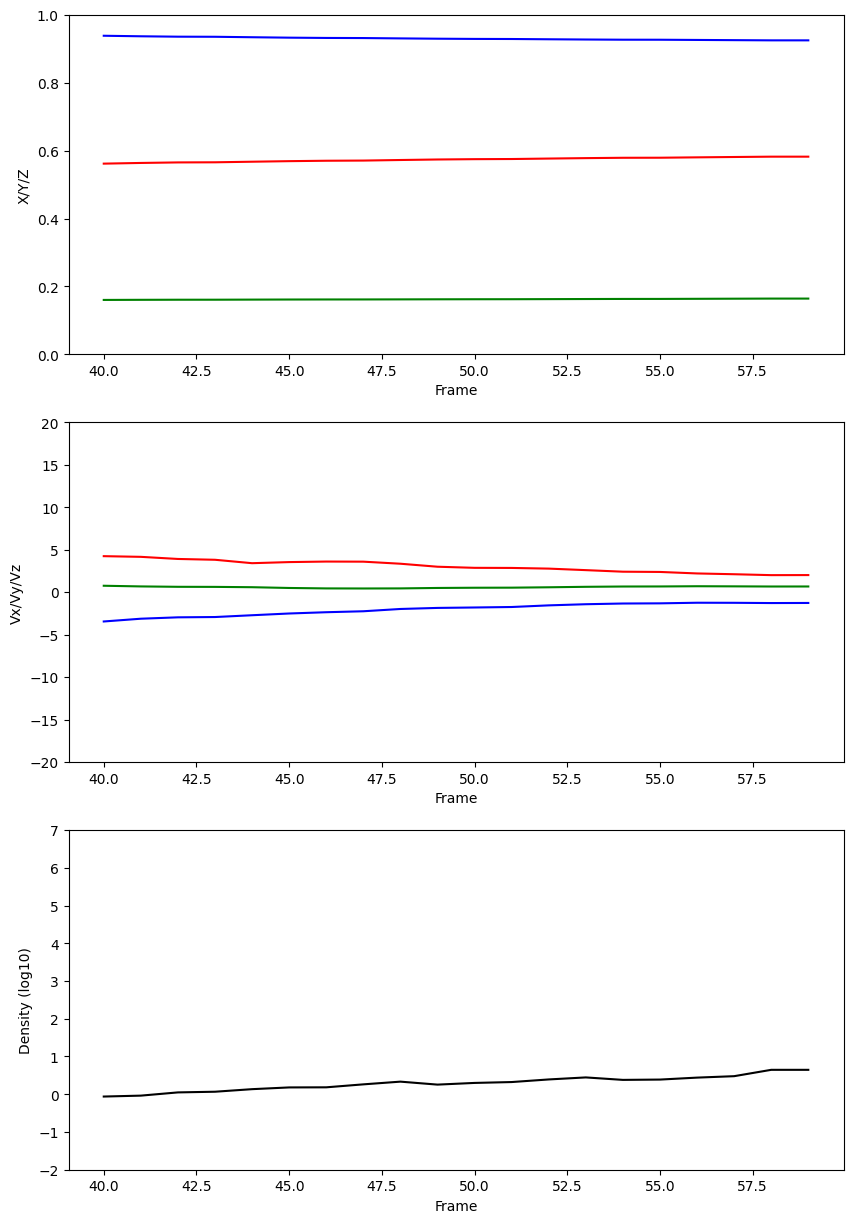

In [7]:
#Same Particle_ids across Initial_Frames
def get_track(df, particle_id):
    track_df = df[df['Particle_id'] == particle_id]
    xpos = track_df['X_i'].values
    ypos = track_df['Y_i'].values
    zpos = track_df['Z_i'].values
    vx = track_df['Vx_i'].values
    vy = track_df['Vy_i'].values
    vz = track_df['Vz_i'].values
    dens = track_df['Density_i'].values
    frames = track_df['Initial_Frame'].values
    fig = plt.figure(figsize=(10, 15))
    ax = fig.add_subplot(311)
    ax.plot(frames, xpos, 'r')
    ax.plot(frames, ypos, 'g')
    ax.plot(frames, zpos, 'b')
    ax.set_xlabel('Frame')
    ax.set_ylabel('X/Y/Z')
    ax.set_ylim([0,1])
    ax = fig.add_subplot(312)
    ax.plot(frames, vx, 'r')
    ax.plot(frames, vy, 'g')
    ax.plot(frames, vz, 'b')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Vx/Vy/Vz')
    ax.set_ylim([-20,20])
    ax = fig.add_subplot(313)
    ax.plot(frames, dens, 'black')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Density (log10)')
    ax.set_ylim([-2,7])
    plt.savefig('track_'+str(particle_id)+'.png')
    plt.show()

get_track(df_timeseries, pid)

## Split data

In [90]:
def plot_prediction(y_true,y_pred, mae, r2, append=''):
    fig = plt.figure(figsize=(6, 6))
    for i in range(1):
        ax = plt.subplot(1, 1, i+1)
        ax.scatter(y_true,y_true-y_pred, c='crimson', s=1e-2)
        ax.plot([0, 0], [1, 1], 'b-')
        ax.set_xlabel('True Values', fontsize=15)
        ax.set_ylabel('True Values - Predictions', fontsize=15)
        ax.set_title(f'{TARGET[i]}: MAE = {mae:.6f}, R2 = {r2:.4f}', fontsize=12)
        #ax.set_xlim([-0.1,1.1])
        #ax.set_ylim([-0.1,1.1])
    fig.tight_layout()
    plt.savefig('Particles_u502_Prediction'+append+'.png')
    plt.show()

def df_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['del_X'] = df['X_f'] - df['X_i']
    df['del_Y'] = df['Y_f'] - df['Y_i']
    df['del_Z'] = df['Z_f'] - df['Z_i']
    df['X_op'] = np.where(np.abs(df['X_i'])<distance_condition, -1, +1)
    df['Y_op'] = np.where(np.abs(df['Y_i'])<distance_condition, -1, +1)
    df['Z_op'] = np.where(np.abs(df['Z_i'])<distance_condition, -1, +1)
    df['X_f'] = np.where(np.abs(df['del_X'])<distance_condition, df['X_f'], df['X_f']+df['X_op'])
    df['Y_f'] = np.where(np.abs(df['del_Y'])<distance_condition, df['Y_f'], df['Y_f']+df['Y_op'])
    df['Z_f'] = np.where(np.abs(df['del_Z'])<distance_condition, df['Z_f'], df['Z_f']+df['Z_op'])
    return df

def df_inverse_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['X_f'] = np.where(df['X_f']>=1, df['X_f']-1, df['X_f'])
    df['X_f'] = np.where(df['X_f']<0, df['X_f']+1, df['X_f'])
    df['Y_f'] = np.where(df['Y_f']>=1, df['Y_f']-1, df['Y_f'])
    df['Y_f'] = np.where(df['Y_f']<0, df['Y_f']+1, df['Y_f'])
    df['Z_f'] = np.where(df['Z_f']>=1, df['Z_f']-1, df['Z_f'])
    df['Z_f'] = np.where(df['Z_f']<0, df['Z_f']+1, df['Z_f'])
    return df


def model_test(model, test_df, distance_condition = 0.5):
    y_pred = model.predict(test_df[FEATURES])
    #y_pred_df = pd.DataFrame({'X_f': y_pred[:, 0], 'Y_f': y_pred[:, 1], 'Z_f': y_pred[:, 2], 'Density_f': y_pred[:, 3]})
    #y_pred_df =  df_inverse_transform(y_pred_df, distance_condition = distance_condition)
    
    return y_pred

def mae_modded(y_true, y_pred):
    mae = np.array([0.,0.,0.])
    mae_diff = np.abs(y_true - y_pred)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    mae = stacked.min(axis=2).mean(axis=0)
    return mae

def r2_modded(y_true, y_pred):
    true_mean = np.mean(y_true,axis=0)
    mae_diff = np.abs(y_true - y_pred)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    r2_residual = stacked.min(axis=2)**2
    mae_diff = np.abs(y_true - true_mean)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    r2_total = stacked.min(axis=2)**2

    return 1-r2_residual.sum(axis=0)/r2_total.sum(axis=0)

In [131]:
df_timeseries_transformed = df_transform(df_timeseries)
#plot_data(df_timeseries, name = 'noncore_')
#plot_data(df_timeseries_transformed, name = 'noncore_extended')
X, y = df_timeseries_transformed[FEATURES], df_timeseries_transformed[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = NTEST_percentage,  random_state=seed)

#y_test = df_inverse_transform(y_test)

## Train model
https://xgboost.readthedocs.io/en/stable/parameter.html

In [132]:
n_estimators    = 1000   #The number of trees in the ensemble, often increased until no further improvements are seen.
max_depth       = 9     #The maximum depth of each tree, often values are between 1 and 10.
eta             = 0.3  #The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
subsample       = 1   #The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
colsample_bytree= 1     #Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

#We will evaluate the model using the best practice of repeated k-fold cross-validation with 3 repeats and 10 folds.
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree, device = 'cpu')

evaluate = 0
if evaluate:
    # evaluate model
    model_score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-3)
    # force scores to be positive
    scores = np.absolute(model_score)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


In [133]:
print(len(X_train))
model.fit(X_train, y_train)

1995188


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device='cpu', early_stopping_rounds=None, enable_categorical=False,
             eta=0.3, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [134]:
model.save_model("Core_Density_v0_more_features_Frame"+str(FRAMES[0])+'_to_'+str(FRAMES[-1])+"_"+MODELFILE)

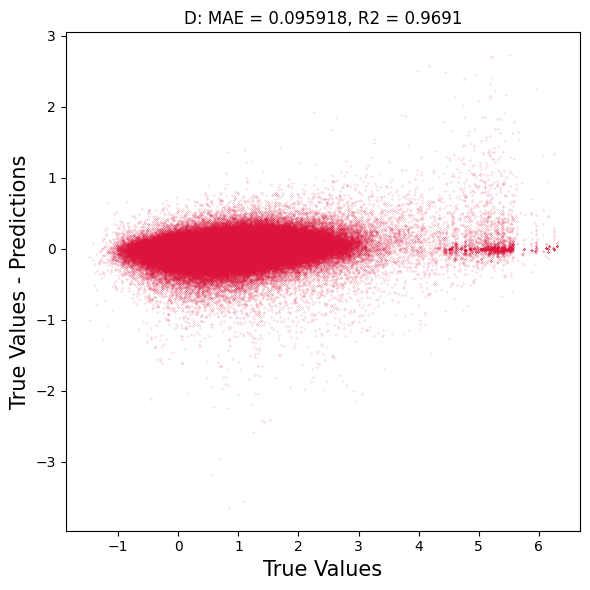

MaE: 0.095918
R2: 0.969


In [138]:
model = xgb.XGBRegressor()
mtype = 'Core'
model.load_model(mtype+'_Density_v0_more_features_Frame40_to_59_nnmodel.json')
ypred, ytrue = model_test(model, X_test), y_test
mae = skm.mean_absolute_error(ytrue.to_numpy(), ypred)
r2 = skm.r2_score(ytrue.to_numpy(),ypred)
plot_prediction(ytrue.to_numpy(),ypred,mae, r2 , append = '_'+mtype+'_Density_v0_more_features')
print('MaE: %.6f' % mae)
print('R2: %.3f' % r2)



## Stats
| Model 	| Loss 	        | n_estimators 	| max_depth 	| eta 	| subsample 	| lambda 	| alpha 	| Density R2 	| Density mae 	| r2 	| remarks 	                                     |
|-------	|-------        |--------------	|-----------	|-----	|-----------	|--------	|-------	|----------	|------	|----	|---------	                                    |
|V0 |squarederror   |1000          	|  8        	|0.1   | 1        	|   1    	|    1  	|0.9225     |0.144852|0.959| Deeper tree|
|V1 |squarederror   |1000          	|  9        	|0.3   | 1        	|   1    	|    1  	|0.9691     |0.095918|0.969| Deeper tree|